In [12]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(r'C:\Users\PC\OneDrive\Masaüstü\tenseclassification\English Tense Classification.csv')  # Replace with your actual file path

# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip()

data['processed_text'] = data['Sentence'].apply(preprocess_text)

# Extract tense indicators
def extract_indicators(text):
    indicators = []
    present_indicators = ['am', 'is', 'are', 'do', 'does', 'have', 'has']
    past_indicators = ['was', 'were', 'did', 'had', 'could', 'would', 'should']
    future_indicators = ['will', 'shall', 'going to', 'gonna']
    
    words = text.split()
    for word in words:
        if word in present_indicators:
            indicators.append(1)
        elif word in past_indicators:
            indicators.append(2)
        elif word in future_indicators:
            indicators.append(3)
    
    # Return the most frequent indicator, or 0 if none found
    if indicators:
        return max(set(indicators), key=indicators.count)
    return 0

data['indicators'] = data['processed_text'].apply(extract_indicators)

# Split data into train and test sets
X = data['processed_text']
y = data['Label'] - 1  # Convert to 0-based index (0:present, 1:past, 2:future)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenization
vocab_size = 10000
max_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [14]:
# Updated Model Architecture with immediate building
from tensorflow.keras import Input

# Model parameters
vocab_size = 10000  # Should match your tokenizer's vocab_size
embedding_dim = 128
lstm_units = 64
dense_units = 32
num_classes = 3  # present, past, future
max_length = 50  # Should match your padding length

# Build the model with explicit input layer to force building
input_layer = Input(shape=(max_length,))

embedding = Embedding(vocab_size, embedding_dim)(input_layer)
lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
lstm2 = Bidirectional(LSTM(lstm_units))(lstm1)
dense1 = Dense(dense_units, activation='relu')(lstm2)
dropout = Dropout(0.5)(dense1)
output = Dense(num_classes, activation='softmax')(dropout)

# Create model
model = tf.keras.Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,481,859 (5.65 MB)

 Trainable params: 1,481,859 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7332 - loss: 0.5716

150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.7343 - loss: 0.5694 - val_accuracy: 0.9987 - val_loss: 0.0034
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 0.9983 - val_loss: 0.0091
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9988 - loss: 0.0063 - val_accuracy: 0.9983 - val_loss: 0.0079
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9979 - val_loss: 0.0110


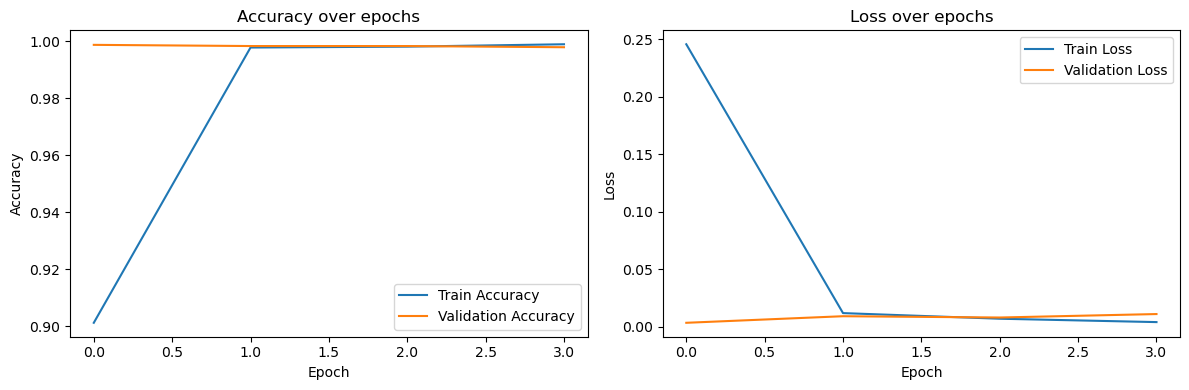

In [15]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
y_pred = best_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Present', 'Past', 'Future']))

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Classification Report:
              precision    recall  f1-score   support

     Present       1.00      1.00      1.00       800
        Past       1.00      1.00      1.00       800
      Future       1.00      1.00      1.00       800

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Test Accuracy: 99.88%


In [17]:
# Combine model predictions with tense indicators for final prediction
def combined_predict(sentence, model, tokenizer, max_length):
    # Preprocess
    processed = preprocess_text(sentence)
    indicator = extract_indicators(processed)
    
    # Model prediction
    seq = tokenizer.texts_to_sequences([processed])
    pad = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    pred = model.predict(pad)
    pred_class = np.argmax(pred, axis=1)[0]
    
    # Combine with indicator if strong indicator exists
    if indicator != 0:
        # Weighted combination (70% model, 30% indicator)
        combined = [0, 0, 0]
        combined[pred_class] += 0.7
        combined[indicator-1] += 0.3
        final_class = np.argmax(combined)
    else:
        final_class = pred_class
    
    return final_class + 1  # Return to 1-based label

# Test the combined prediction
test_sentence = "The scientists will conduct experiments next month."
prediction = combined_predict(test_sentence, best_model, tokenizer, max_length)
print(f"Sentence: '{test_sentence}'")
print(f"Predicted tense: {prediction} (1=Present, 2=Past, 3=Future)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sentence: 'The scientists will conduct experiments next month.'
Predicted tense: 3 (1=Present, 2=Past, 3=Future)


In [18]:
# Save the final model and tokenizer
best_model.save('tense_classifier.h5')

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def predict_tense():
    # Load model and tokenizer
    model = tf.keras.models.load_model('tense_classifier.h5')
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    while True:
        sentence = input("\nEnter a sentence (or 'quit' to exit): ")
        if sentence.lower() == 'quit':
            break
        
        tense = combined_predict(sentence, model, tokenizer, max_length)
        tense_map = {1: "Present Tense", 2: "Past Tense", 3: "Future Tense"}
        print(f"\nPredicted tense: {tense_map[tense]}")
        
        # Show confidence
        processed = preprocess_text(sentence)
        seq = tokenizer.texts_to_sequences([processed])
        pad = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
        pred = model.predict(pad)[0]
        print(f"Confidence: Present: {pred[0]*100:.1f}%, Past: {pred[1]*100:.1f}%, Future: {pred[2]*100:.1f}%")

# Run the interactive predictor
predict_tense()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step

Predicted tense: Future Tense
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Confidence: Present: 0.0%, Past: 0.0%, Future: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Predicted tense: Present Tense
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Confidence: Present: 100.0%, Past: 0.0%, Future: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Predicted tense: Past Tense
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Confidence: Present: 0.0%, Past: 100.0%, Future: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

Predicted tense: Past Tense
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Confidence: Present: 0.0%, Past: 99.9%, Future: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Predicted tense: Past Tense
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
